<a href="https://colab.research.google.com/github/CelaPablo/SOA-EA2/blob/master/HPC/Cela_Pablo_ejercicio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Introducción

En el siguiente ejercicio, se calcula el centro de masa de una cantidad N de cuerpos libres en el espacio.

El centro de masa [4] es una posición definida en relación a un objeto o a un sistema de objetos. Es el promedio de la posición de todas las partes del sistema, ponderadas de acuerdo a sus masas.

Lo interesante acerca del centro de masa de un objeto o de un sistema, es que es el punto en donde actúa cualquier fuerza uniforme sobre el objeto. Esto es útil porque facilita resolver problemas de mecánica en donde tenemos que describir el movimiento de objetos con formas raras y de sistemas complicados.

Función para calcular el centro de masa de un sistema:

<center> CDMx = Σ(Xi * Mi) / Σ(Mi) </center>
<center> CDMy = Σ(Yi * Mi) / Σ(Mi) </center>
<center> CDMz = Σ(Zi * Mi) / Σ(Mi) </center>

A modo de demostración del ejercicio, se incluyo al inicio el calculo en el lenugaje Python[1,2,3] con el fin de representar en forma gráfica el resultado obtenido. En él, se pueden ver graficados los N cuerpos en color VERDE, y el punto de centro de masa en color ROJO.

En este ejercico, se busca realizar una comparación directa entre una ejecución en serie y una en paralelo sobre el mismo juego de valores. Para ello, se utilizara OpenMP[5] para realizar en varios hilos de ejecución una programación paralela.



---
# Armado del ambiente

No son necesarias ejecucuiones previas.

---
# Desarrollo

Ejemplo desarrollado en Python a modo de demostración grafico.

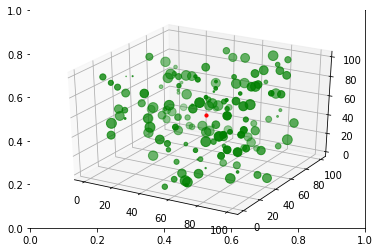

In [ ]:
#@title ## Parámetros de ejecución

#@markdown ---
#@markdown ### Especifique la cantidad de cuerpos libres:
cuerpos = 150#@param {type:"number"}

try:
  import numpy as np
  import matplotlib.pyplot as plt
  from matplotlib import animation, rc
  from IPython.display import HTML

  colores = ['green'] * cuerpos

  # Inicializo valores de X, Y, Z y masa. --------------------------------------
  x_cpu  = np.random.uniform(0, 100, size=cuerpos)
  y_cpu  = np.random.uniform(0, 100, size=cuerpos)
  z_cpu  = np.random.uniform(0, 100, size=cuerpos)
  m_cpu  = np.random.uniform(0, 100, size=cuerpos)

  m = 0
  cdmx = 0
  cdmy = 0
  cdmz = 0
  masas = 0

  for i in range( 0, cuerpos ):
    m = m_cpu[i]
    cdmx += x_cpu[i] * m
    cdmy += y_cpu[i] * m
    cdmz += z_cpu[i] * m
    masas += m

  cdmx /= masas
  cdmy /= masas
  cdmz /= masas

  # Representacion del resultado. ----------------------------------------------
  fig, ax = plt.subplots()
  ax1 = fig.add_subplot(projection="3d")
  ax1.scatter(x_cpu, y_cpu, z_cpu, c=colores, s=m_cpu)
  ax1.scatter(cdmx, cdmy, cdmz, c='red', s=10)
except ModuleNotFoundError:
  print("Error en modulos utilizados")
except:
  print("Houston we have a problem!")


In [ ]:

code = """
// Calculo de centro de masas de cuerpos libres con OpenMP - usando C.

#include <iostream>
#include <vector>
#include <cstdlib>
#include <sys/time.h>
#include <omp.h>

// ----------------------------------------------------------------------------
// Macros que miden el tiempo.

static double dHashTiempoHistory[3];
static struct timeval tv;

#define TIEMPO_INI( h )      \
   gettimeofday(&tv,NULL);   \
   dHashTiempoHistory[ h ] = tv.tv_sec + tv.tv_usec/1000000.0;
   
   
#define TIEMPO_FIN( h )      \
   gettimeofday(&tv,NULL);   \
   dHashTiempoHistory[ h ] = ((tv.tv_sec + tv.tv_usec/1000000.0) - dHashTiempoHistory[ h ]) * 1000;
#define TIEMPO_GET( h ) dHashTiempoHistory[ h ]

#define HTH_TOTAL      1
#define HTH_CDM_SEC    2
#define HTH_CDM_OMP    3

// ----------------------------------------------------------------------------

int main(int argc, char* argv[]) 
{ 
  TIEMPO_INI( HTH_TOTAL )

  // Lectura de parametros.
  if( argc != 2 )
  {
      std::cerr<<"Error en los parametros de indicar: (Tamanio vector)."<<argc<<std::endl;
      exit( -1 );
  }

  int cantidad = atoi( argv[1] );

  // --------------------------------------------
  // Defino la memoria de los vectores.

  std::vector<double> x_omp( cantidad );
  std::vector<double> y_omp( cantidad );
  std::vector<double> z_omp( cantidad );
  std::vector<double> m_omp( cantidad );
  
  int i;
  float masas = 0;

  // --------------------------------------------
  // Variables para ejecucion en serie.
  float x_serie = 0, y_serie = 0, z_serie = 0;

  // --------------------------------------------
  // Variables para ejecucion en paralelo.
  float x_paralelo = 0, y_paralelo = 0, z_paralelo = 0;

  // --------------------------------------------
  // Inicializacion de los vectores.
  for (int i=0;i<x_omp.size();i++)
  {
    x_omp[i] = (rand()/(double)RAND_MAX)*0.73;
    y_omp[i] = (rand()/(double)RAND_MAX)*0.73;
    z_omp[i] = (rand()/(double)RAND_MAX)*0.73;
    m_omp[i] = (rand()/(double)RAND_MAX)*0.73;
  }

  // --------------------------------------------
  // Realizo el calculo del centro de masa en forma secuencial.

  TIEMPO_INI( HTH_CDM_SEC )
  for(i=0;i<cantidad;i++)
  {
    float m = m_omp[i];
    x_serie += x_omp[i] * m;
    y_serie += y_omp[i] * m;
    z_serie += z_omp[i] * m;
    masas += m;
  }

  x_serie /= masas;
  y_serie /= masas;
  z_serie /= masas;

  masas = 0;

  TIEMPO_FIN( HTH_CDM_SEC )

  // --------------------------------------------
  // Realizo el calculo del centro de masa con OpenMP.

  TIEMPO_INI( HTH_CDM_OMP )

  #pragma omp parallel shared(masas, x_paralelo, y_paralelo, z_paralelo)
  {
    int id = omp_get_thread_num();
    int nt = omp_get_num_threads();
    int size = cantidad / nt;
    int init = id * size;
    int end = init + size - 1;

    for(i = init; i <= end; i++)
    {
      float m = m_omp[i];
      x_paralelo += x_omp[i] * m;
      y_paralelo += y_omp[i] * m;
      z_paralelo += z_omp[i] * m;
      masas += m;
    }
  }
 
  x_paralelo /= masas;
  y_paralelo /= masas;
  z_paralelo /= masas;

  TIEMPO_FIN( HTH_CDM_OMP )

  // --------------------------------------------
  // Muestro los resultados.
  std::cout<<"Resulatdos - Posicion del centro de masa:" <<std::endl;
  std::cout<<"Ejecucion en serie: ("<<x_serie<<"; "<<y_serie<<"; "<<z_serie<<")"<<std::endl;
  std::cout<<"Resulatdos - Posicion del centro de masa:" <<std::endl;
  std::cout<<"Ejecucion en paralelo: ("<<x_paralelo<<"; "<<y_paralelo<<"; "<<z_paralelo<<")"<<std::endl;

  TIEMPO_FIN( HTH_TOTAL )

  std::cout<<"Valores Reales :" <<std::endl;
  std::cout<<"Tiempo TOTAL   : "<<TIEMPO_GET(HTH_TOTAL   )<<" [ms]"<<std::endl;
  std::cout<<"Tiempo centro de masa Sec real : "<<TIEMPO_GET(HTH_CDM_SEC)<<" [ms]"<<std::endl;
  std::cout<<"Tiempo centro de masa Omp real : "<<TIEMPO_GET(HTH_CDM_OMP)<<" [ms]"<<std::endl;
  std::cout<<std::endl;
  std::cout<<"SpeedUp          :  (tiempo Secuencial/tiempo paralelo) : "<<TIEMPO_GET(HTH_CDM_SEC)<<" / "<<TIEMPO_GET(HTH_CDM_OMP)<<" = "<<TIEMPO_GET(HTH_CDM_SEC)/TIEMPO_GET(HTH_CDM_OMP)<<std::endl;
  std::cout<<"Eficiencia       : SpeedUp/nro procesadores            : "<<TIEMPO_GET(HTH_CDM_SEC)/TIEMPO_GET(HTH_CDM_OMP)<<" / "<<omp_get_num_procs()<<" = "<<TIEMPO_GET(HTH_CDM_SEC)/(omp_get_num_procs()*TIEMPO_GET(HTH_CDM_OMP))<<std::endl;
  std::cout<<"Coste Sec        : nro procesadores*Tiempo             : "<<1<<" * "<<TIEMPO_GET(HTH_CDM_SEC)<<" = "<<TIEMPO_GET(HTH_CDM_SEC)<<std::endl;
  std::cout<<"Coste Omp        : nro procesadores*Tiempo             : "<<omp_get_num_procs()<<" * "<<TIEMPO_GET(HTH_CDM_OMP)<<" = "<<omp_get_num_procs()*TIEMPO_GET(HTH_CDM_OMP)<<std::endl;
  std::cout<<"Funcion Overhead : Coste Omp - tiempo Secuencial       : "<<omp_get_num_procs()*TIEMPO_GET(HTH_CDM_OMP)<<" - "<<TIEMPO_GET(HTH_CDM_SEC)<<" = "<<(omp_get_num_procs()*TIEMPO_GET(HTH_CDM_OMP))-TIEMPO_GET(HTH_CDM_SEC)<<std::endl;
  std::cout<<"-------------------------------------------------------------------------------------"<<std::endl;
  std::cout<<std::endl;
  std::cout<<"Valores Ideal: "<<std::endl;
  TIEMPO_GET(HTH_CDM_OMP) = TIEMPO_GET(HTH_CDM_SEC) / 2;
  std::cout<<"Tiempo centro de masa Sec ideal : "<<TIEMPO_GET(HTH_CDM_SEC)<<" [ms]"<<std::endl;
  std::cout<<"Tiempo centro de masa Omp ideal : "<<TIEMPO_GET(HTH_CDM_OMP)<<" [ms]"<<std::endl;

  std::cout<<"SpeedUp          : (tiempo Secuencial/tiempo paralelo) : "<<TIEMPO_GET(HTH_CDM_SEC)<<" / "<<TIEMPO_GET(HTH_CDM_OMP)<<" = "<<TIEMPO_GET(HTH_CDM_SEC)/TIEMPO_GET(HTH_CDM_OMP)<<std::endl;
  std::cout<<"Eficiencia       : SpeedUp/nro procesadores            : "<<TIEMPO_GET(HTH_CDM_SEC)/TIEMPO_GET(HTH_CDM_OMP)<<" / "<<omp_get_num_procs()<<" = "<<TIEMPO_GET(HTH_CDM_SEC)/(omp_get_num_procs()*TIEMPO_GET(HTH_CDM_OMP))<<std::endl;
  std::cout<<"Coste Sec        : nro procesadores*Tiempo             : "<<1<<" * "<<TIEMPO_GET(HTH_CDM_SEC)<<" = "<<TIEMPO_GET(HTH_CDM_SEC)<<std::endl;
  std::cout<<"Coste Omp        : nro procesadores*Tiempo             : "<<omp_get_num_procs()<<" * "<<TIEMPO_GET(HTH_CDM_OMP)<<" = "<<omp_get_num_procs()*TIEMPO_GET(HTH_CDM_OMP)<<std::endl;
  std::cout<<"Funcion Overhead : Coste Omp - tiempo Secuencial       : "<<omp_get_num_procs()*TIEMPO_GET(HTH_CDM_OMP)<<" - "<<TIEMPO_GET(HTH_CDM_SEC)<<" = "<<(omp_get_num_procs()*TIEMPO_GET(HTH_CDM_OMP))-TIEMPO_GET(HTH_CDM_SEC)<<std::endl;

  }
  // ----------------------------------------------------------------------------

"""
text_file = open("ejercicioTres.cpp", "w")
text_file.write(code)
text_file.close()


In [ ]:
!g++ -o ejercicioTres -fopenmp ejercicioTres.cpp

Cantidad de Hilos a ejecutar en forma paralela:

In [ ]:
%env OMP_NUM_THREADS=4

env: OMP_NUM_THREADS=4


Ejecución del calculo del centro de masa en Serie y Paralela - **Parametro: Cantidad de cuerpos libres.**

In [ ]:
!./ejercicioTres 15000000

Resulatdos - Posicion del centro de masa:
Ejecucion en serie: (0.366608; 0.366698; 0.366856)
Resulatdos - Posicion del centro de masa:
Ejecucion en paralelo: (0.361664; 0.364415; 0.362797)
Valores Reales :
Tiempo TOTAL   : 1591.44 [ms]
Tiempo centro de masa Sec real : 282.962 [ms]
Tiempo centro de masa Omp real : 88.5708 [ms]

SpeedUp          :  (tiempo Secuencial/tiempo paralelo) : 282.962 / 88.5708 = 3.19475
Eficiencia       : SpeedUp/nro procesadores            : 3.19475 / 2 = 1.59738
Coste Sec        : nro procesadores*Tiempo             : 1 * 282.962 = 282.962
Coste Omp        : nro procesadores*Tiempo             : 2 * 88.5708 = 177.142
Funcion Overhead : Coste Omp - tiempo Secuencial       : 177.142 - 282.962 = -105.82
-------------------------------------------------------------------------------------

Valores Ideal: 
Tiempo centro de masa Sec ideal : 282.962 [ms]
Tiempo centro de masa Omp ideal : 141.481 [ms]
SpeedUp          : (tiempo Secuencial/tiempo paralelo) : 282.962 /

---
# Tabla de pasos de ejecución del programa

Solo aplicable a la comparacion entre Serie - Paralelo con OpenMP

 Procesador | Funciòn | Detalle
------------|---------|----------
CPU   |  #includes     | Librerias necsarias para el desarrollo del ejercicion en C++.
CPU   | #define     | Definicion de macros utilizadas en el proceso.
CPU   | main()     | Funcion principal.
CPU   | TIEMPO_INI    | Toma el tiempo inicial para la ejecucion en serie.
CPU   | argc != 2   | Validacion de parametro.
CPU   | std::vector    | Definicion de los vectores X, Y, Z y masa a utilizar.
CPU   | for(...)  | Calculo de centro de masa en serie.
CPU   | TIEMPO_FIN   | Toma el tiempo final para la ejecucion en serie.
CPU   | TIEMPO_INI   | Toma el tiempo inicial para la ejecucion en paralelo.
CPU   | #pragma   | Defino el sector que se va a ejecutar en paralelo, indicando que variables van a ser compartidas por los distintos hilos de ejecucion.
CPU   | omp_get_thread_num  | Obtengo el numero de hilo que esta ejecutando.
CPU   | omp_get_num_threads | Obtengo la cantidad de hilos en ejecucion.
CPU   | size - init - end | Defino la cantidad de operaciones que debe ejecutar cada hilo.
CPU   | for(...)   | Ejecucion del calculo del centro de masa para cada hilo en ejecucion.
CPU   | TIEMPO_FIN   | Toma el tiempo final para la ejecucion en paralelo.
CPU   | std::   | Impresion de los resultados.
CPU   | open(...)   | Apertura del archivo C++.
CPU   | write(...)   | Escritura del archivo C++.
CPU   | write(...)   | Cierre del archivo C++.
CPU   | !g++   | Compilacion del codigo.
CPU   | %env   | Definicion de cantidad hijos a ejecutar el codigo en paralelo.
CPU   | !./ejercicioTres   | Ejecucion del codigo.



---
# Conclusión

Este ejercicio se utilizo para comprender el funcionamiento en paralelo con hilos de ejecución a traves de OpenMP.

En los casos cuando la cantidad de cuerpo libres a calcular el CDM es relativamente pequeño, la ejecución en serie obtiene mejores resultados debido a q se agrega un tiempo extra en comenzar a ejecutar las operaciones en paralelo. En cambio, cuando la cantidad de cuerpos libres son muchas, en paralelo se ejecutan hasta 3 veces mas rapido, gracias a que cada hilo resuelve parte del problema y todo se ejecuta en fomra simultanea.

## Pasos mas relevantes
Para la ejecución en paralelo:

1- Definir la zona critica que se va a ejecutar en paralelo. 

2- Definir las variables que van a compartir los hilos y los que no.

3- Calcular el trabajo que debe realizar cada hilo.


---
# Bibliografía

[1] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[4] Centro de Masa: [Wiki](https://es.wikipedia.org/wiki/Centro_de_masas)

[5] OpenMP: [Wiki](https://es.wikipedia.org/wiki/OpenMP#:~:text=OpenMP%20es%20una%20interfaz%20de,modelo%20de%20ejecuci%C3%B3n%20fork%2Djoin.)